In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
data = pd.read_csv('Datatp2.csv', index_col=0)
data = data.reset_index(drop=True)
data.head()

,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,0.458818,0.483091,0.406909,0.297818,0.395273,0


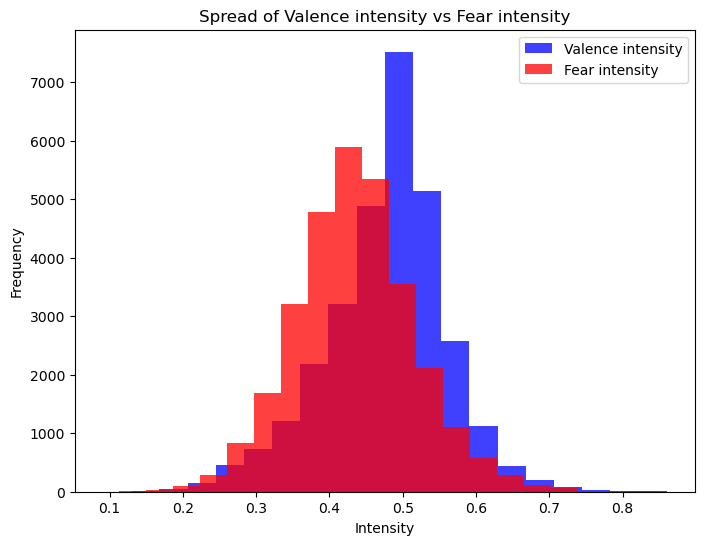

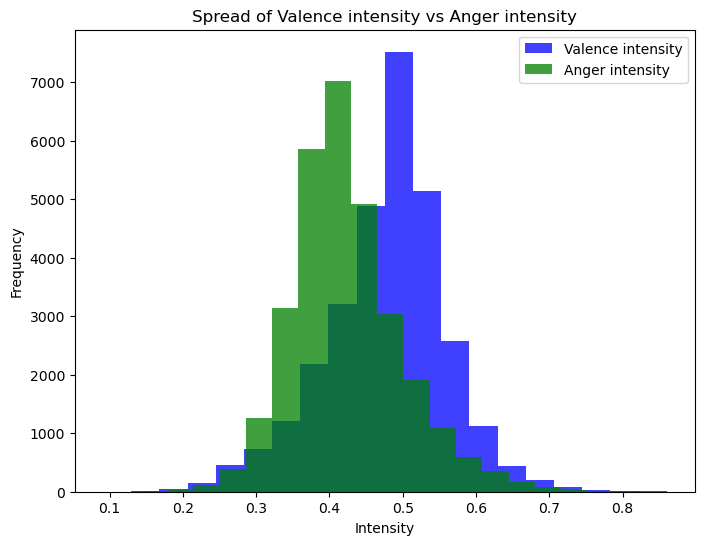

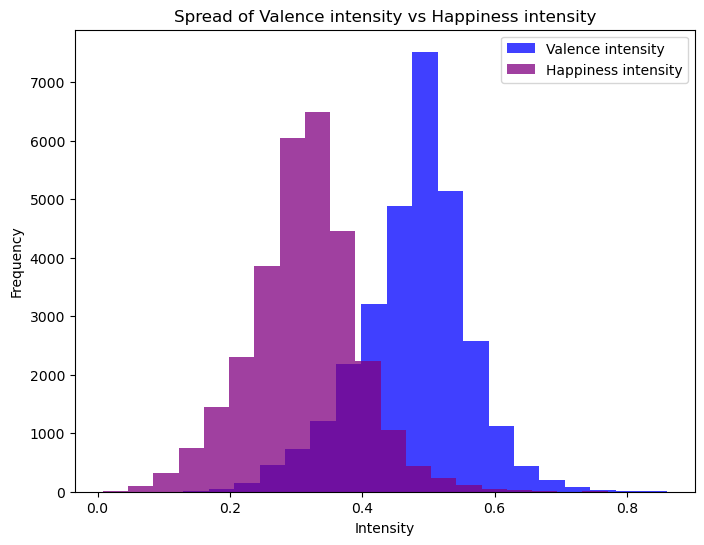

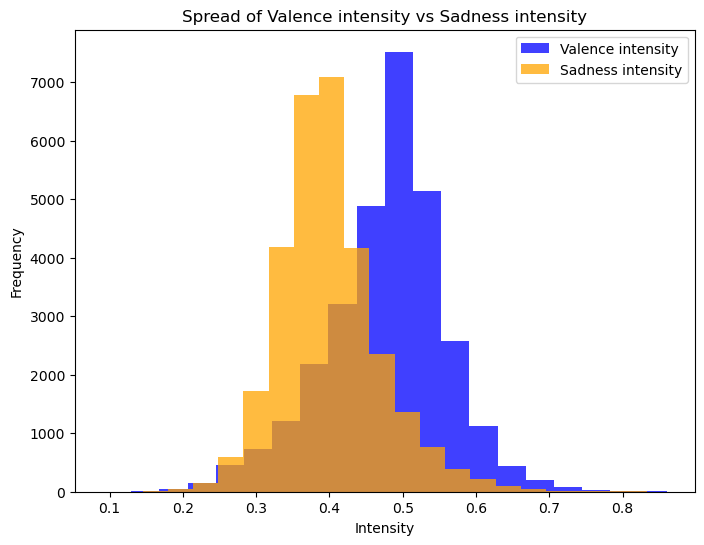

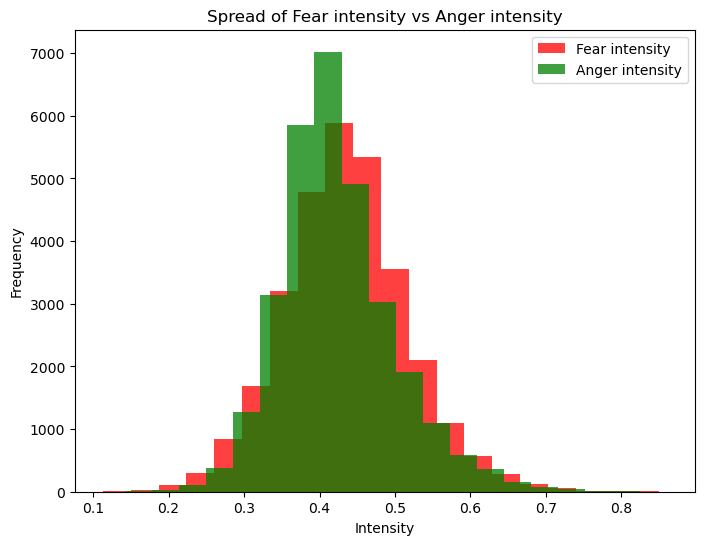

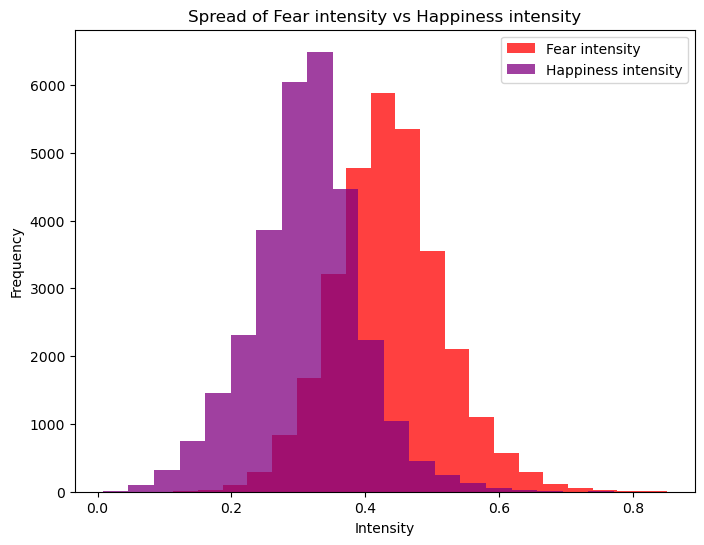

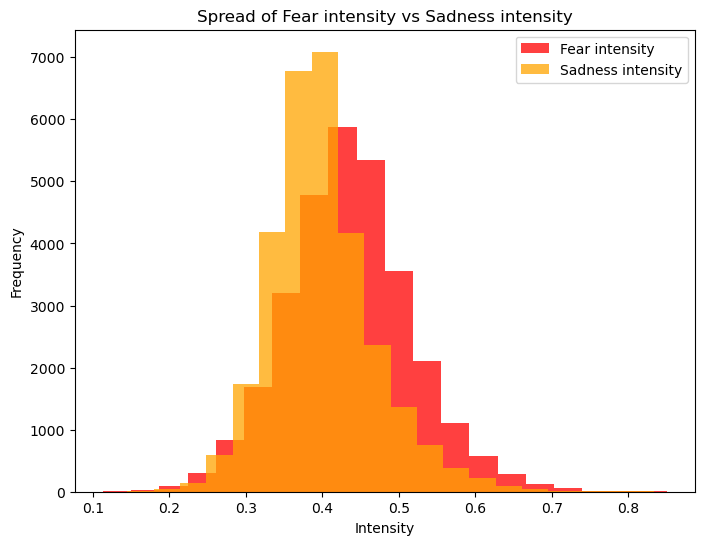

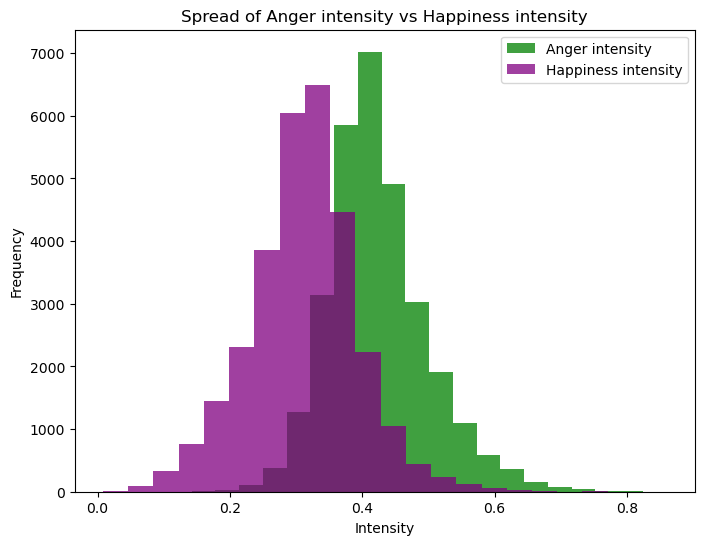

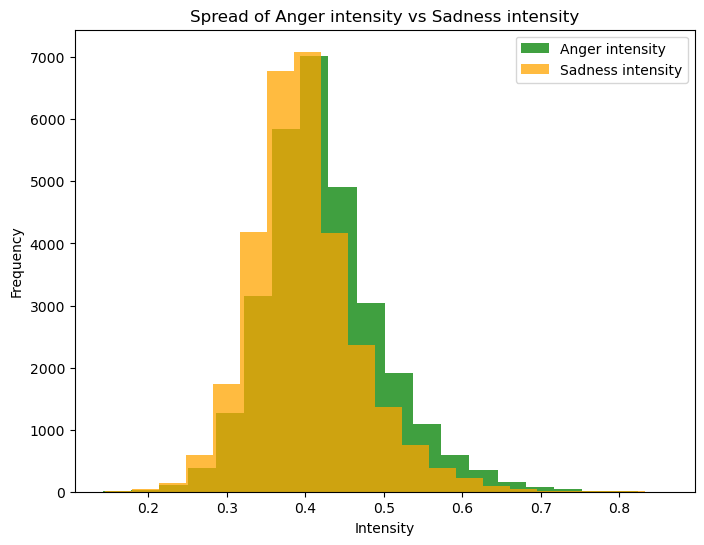

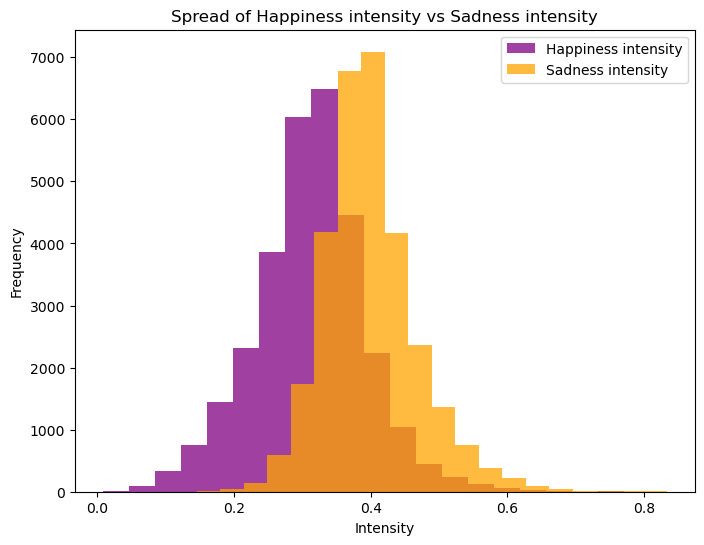

In [3]:
columns = list(data.drop(columns=['sentiment']).columns)
colors = ['blue', 'red', 'green', 'purple', 'orange']  

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        plt.figure(figsize=(8, 6)) 
        sns.histplot(data[columns[i]], color=colors[i], label=columns[i].replace('_', ' ').capitalize(),bins = 20, multiple='stack', edgecolor='None')
        sns.histplot(data[columns[j]], color=colors[j], label=columns[j].replace('_', ' ').capitalize(), bins=20 , multiple='stack', edgecolor='None')
        
        
        plt.title(f"Spread of {columns[i].replace('_', ' ').capitalize()} vs {columns[j].replace('_', ' ').capitalize()}")
        plt.xlabel("Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()


In [4]:
#seperate the features (FTS) and the target (T)

FTS = data.drop('sentiment', axis = 1)
T = data['sentiment']


In [5]:
# we create a dictionary to store all the dataframes related to each k
from sklearn.cluster import KMeans

kmeans_dfs = {}
for k in range(2,11):
    k_means_model = KMeans(n_clusters = k, random_state = 42)
    labels = k_means_model.fit_predict(FTS)
    df = FTS.copy()
    df['Cluster'] = labels
    kmeans_dfs[k] = df

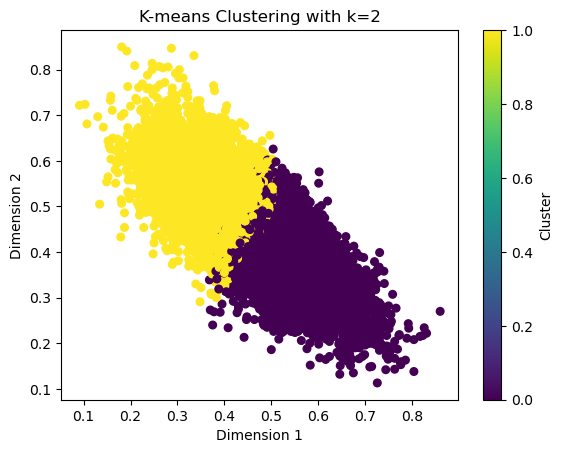

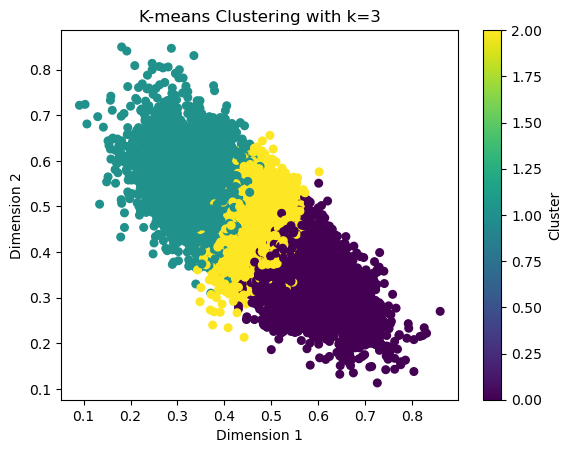

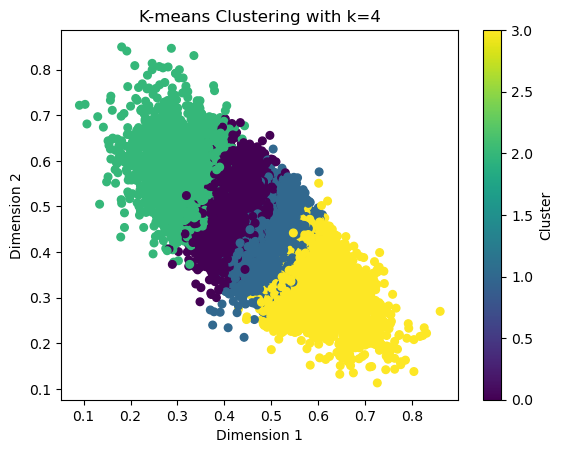

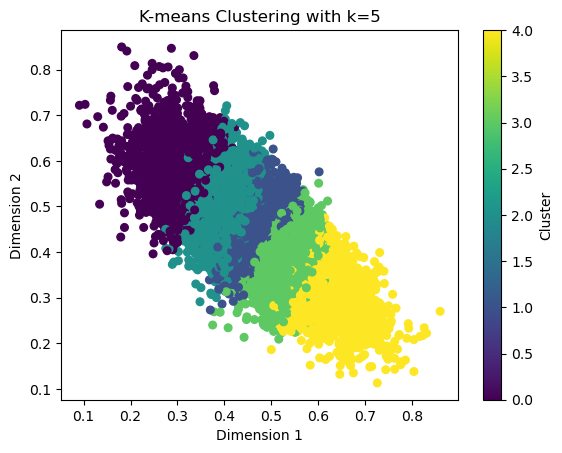

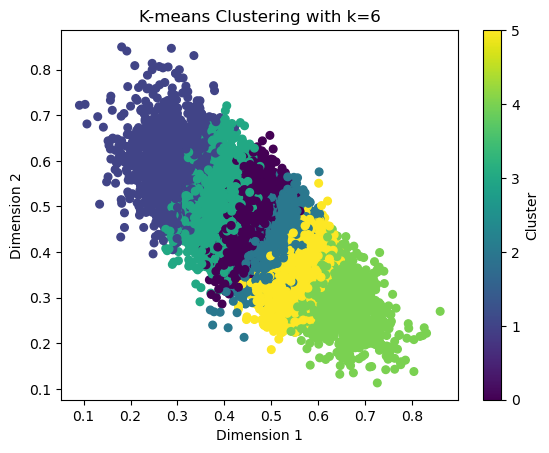

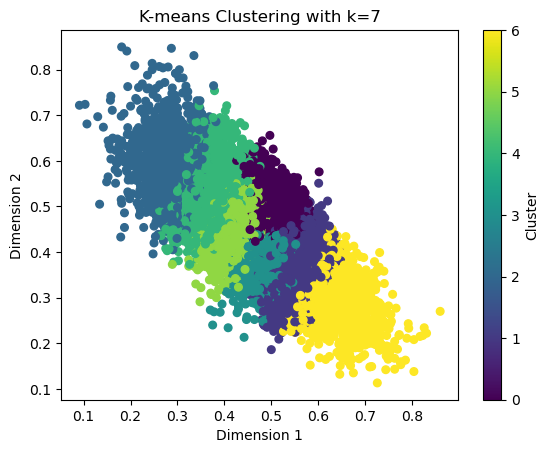

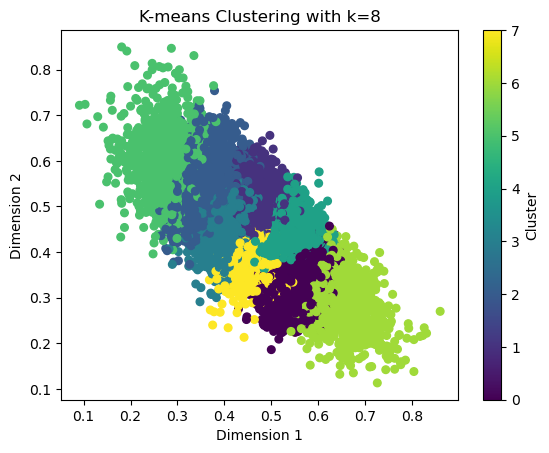

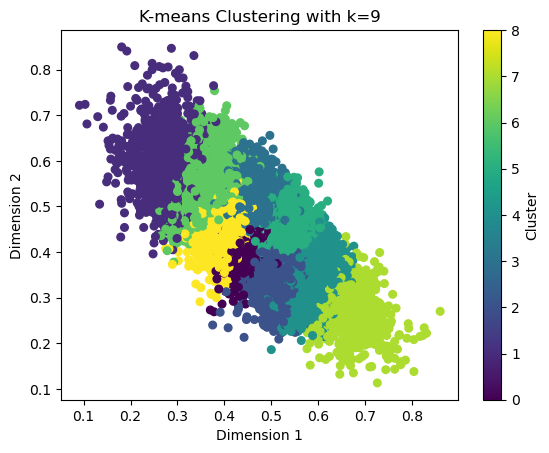

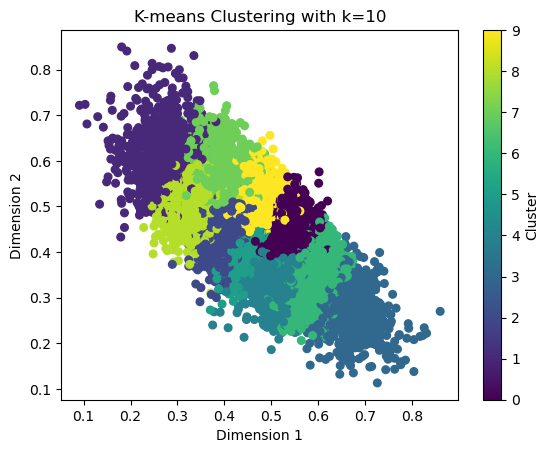

In [6]:
#normal plotting, we can use T-SNE or UMAP to reduce dimensions and have a better look
for k, df in kmeans_dfs.items():
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['Cluster'], cmap='viridis', s=30)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(f'K-means Clustering with k={k}')
    plt.colorbar(label='Cluster')
    plt.show()

# Overlap 


In [7]:

# Compute Euclidean distance between two vectors
def compute_euclidean_distance(vec1, vec2):
    if len(vec1) != len(vec2):
        raise ValueError("Vectors must have the same dimensions.")
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

# Calculate the cluster centers by averaging feature values for each cluster
def calculate_cluster_centers(data):
    return data.groupby('Cluster').mean()

# Compute intra-cluster distance for a given cluster
def intra_cluster_distance(cluster_id, data):
    cluster_centers = calculate_cluster_centers(data)
    cluster_points = data[data['Cluster'] == cluster_id].drop('Cluster', axis=1)
    cluster_center = cluster_centers.loc[cluster_id]

    # Compute distances from each point in the cluster to the cluster center
    distances = [compute_euclidean_distance(point, cluster_center) for _, point in cluster_points.iterrows()]
    return max(distances)

# Compute inter-cluster distance between two clusters
def inter_cluster_distance(cluster_a, cluster_b, data):
    cluster_centers = calculate_cluster_centers(data)
    cluster_a_points = data[data['Cluster'] == cluster_a].drop('Cluster', axis=1)
    cluster_b_points = data[data['Cluster'] == cluster_b].drop('Cluster', axis=1)

    # Calculate minimum distances between points in each cluster and the center of the other cluster
    min_dist_a_to_b = min(
        compute_euclidean_distance(point, cluster_centers.loc[cluster_b])
        for _, point in cluster_a_points.iterrows()
    )
    min_dist_b_to_a = min(
        compute_euclidean_distance(point, cluster_centers.loc[cluster_a])
        for _, point in cluster_b_points.iterrows()
    )

    return min(min_dist_a_to_b, min_dist_b_to_a)

# Compute the overlap measure between two clusters
def compute_overlap(cluster_a, cluster_b, data):
    intra_a = intra_cluster_distance(cluster_a, data)
    intra_b = intra_cluster_distance(cluster_b, data)
    inter_ab = inter_cluster_distance(cluster_a, cluster_b, data)
    return (intra_a + intra_b) / (2 * inter_ab)


In [9]:
# Function to calculate overlap matrix for clusters
def compute_overlap_matrix(data):
    clusters = data['Cluster'].unique()
    overlap_matrix = pd.DataFrame(index=clusters, columns=clusters)

    # Calculate overlap for each pair of clusters
    for cluster_a in clusters:
        for cluster_b in clusters:
            # Avoid redundant calculations
            if pd.notnull(overlap_matrix.at[cluster_a, cluster_b]):
                continue

            overlap_value = compute_overlap(cluster_a, cluster_b, data)
            overlap_matrix.at[cluster_a, cluster_b] = overlap_value
            overlap_matrix.at[cluster_b, cluster_a] = overlap_value  # Symmetric matrix

    return overlap_matrix

# Iterate through all DataFrames and compute overlap matrices
for k, df in kmeans_dfs.items():
    print(f"Results for K={k}")
    print(compute_overlap_matrix(df))


Results for K=2
           0          1
0  94.187681    4.38029
1    4.38029  55.546107
Results for K=3
           2          0         1
2  46.289651   4.485409  3.378114
0   4.485409  46.400475   1.74505
1   3.378114    1.74505  45.09553
Results for K=4
           1          3          0          2
1  41.911696   4.519674   3.627159   1.426201
3   4.519674  40.812309   1.616232   1.103023
0   3.627159   1.616232  40.736241   3.358197
2   1.426201   1.103023   3.358197  22.928033
Results for K=5
           1          3          4          2          0
1  36.555997   4.542988   1.704373   3.468672   1.356445
3   4.542988  43.375329   4.197525   1.479576   0.984375
4   1.704373   4.197525  35.686242   1.025519   0.822557
2   3.468672   1.479576   1.025519  23.311128   3.335945
0   1.356445   0.984375   0.822557   3.335945  28.070681
Results for K=6
           2          0          5          4          3          1
2  54.424258   5.718935   4.805814   1.878652   1.703358   1.067384
0   

# Silhouette Score

In [11]:
# Function to compute and print Silhouette Score for each K
def compute_silhouette_scores(kmeans_dfs):
    for k, df in kmeans_dfs.items():
        print(f"Silhouette score for K={k}")
        # Extract features and labels
        features = df.drop(columns=['Cluster'])
        labels = df['Cluster']
        # Compute Silhouette Score
        score = silhouette_score(features, labels, metric='euclidean')
        print(score)

# Call the function
compute_silhouette_scores(kmeans_dfs)

Silhouette score for K=2
0.4309305032755166
Silhouette score for K=3
0.3423241940746704
Silhouette score for K=4
0.29654022320551854
Silhouette score for K=5
0.26112771660104644
Silhouette score for K=6
0.21515321858961106
Silhouette score for K=7
0.20466052696455905
Silhouette score for K=8
0.19981659470810284
Silhouette score for K=9
0.19586951923840848
Silhouette score for K=10
0.19479334040870913


In [12]:
# K-Means assign cluster labels as arbitrary integers (e.g., 0, 1, 2), we need to match them
# Create a modified version of the dataset with updated sentiment labels
comparison_data = data.copy()
comparison_data['sentiment'] = comparison_data['sentiment'].map({-1: 1, 0: 2, 1: 0})

# Define the true labels and predicted cluster assignments
true_labels = comparison_data['sentiment']
predicted_labels = kmeans_dfs[3]['Cluster']

# Calculate precision, recall, and F1-score for the clustering results
cluster_precision = precision_score(true_labels, predicted_labels, average='macro')
cluster_recall = recall_score(true_labels, predicted_labels, average='macro')
cluster_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Display the evaluation metrics
print("Clustering Precision: ", cluster_precision)
print("Clustering Recall: ", cluster_recall)
print("Clustering F1 Score: ", cluster_f1)


Clustering Precision:  0.755919530010392
Clustering Recall:  0.7101666666666667
Clustering F1 Score:  0.7053979907726137


# Question 3


For threshold = 0.0000
Silhouette score for K = 29935, threshold = 0.0000 is 0.3992


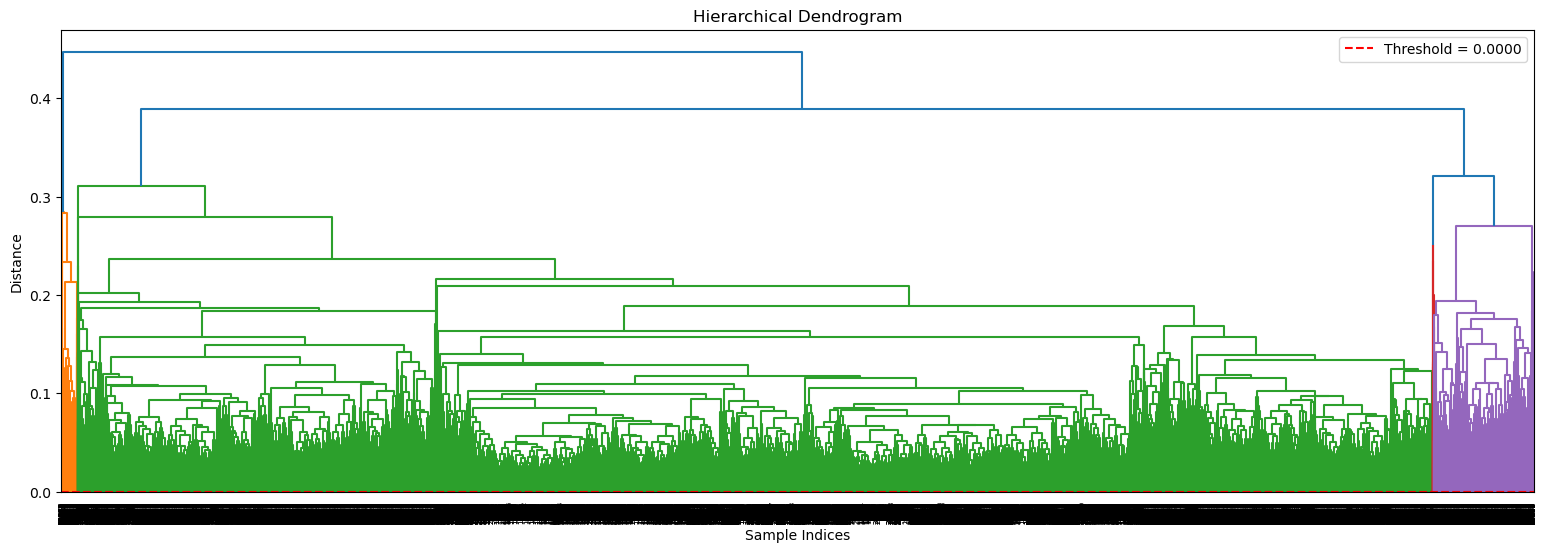

For threshold = 0.0894
Silhouette score for K = 345, threshold = 0.0894 is 0.3992


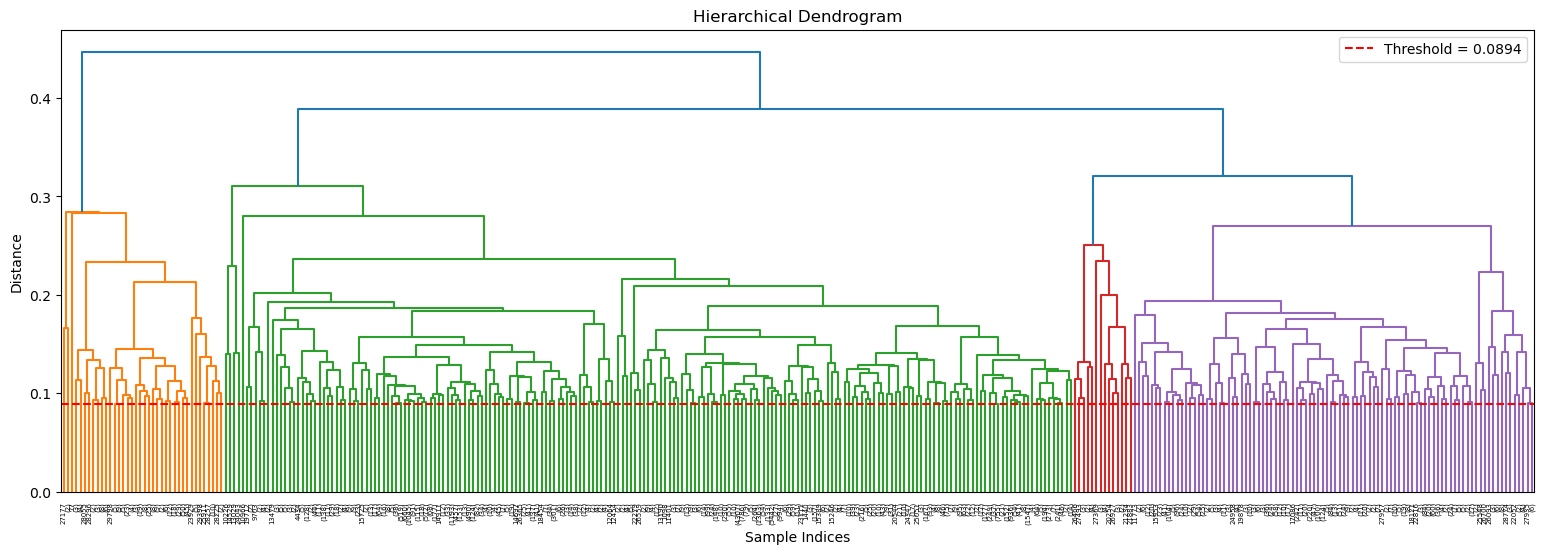

For threshold = 0.1788
Silhouette score for K = 28, threshold = 0.1788 is 0.3992


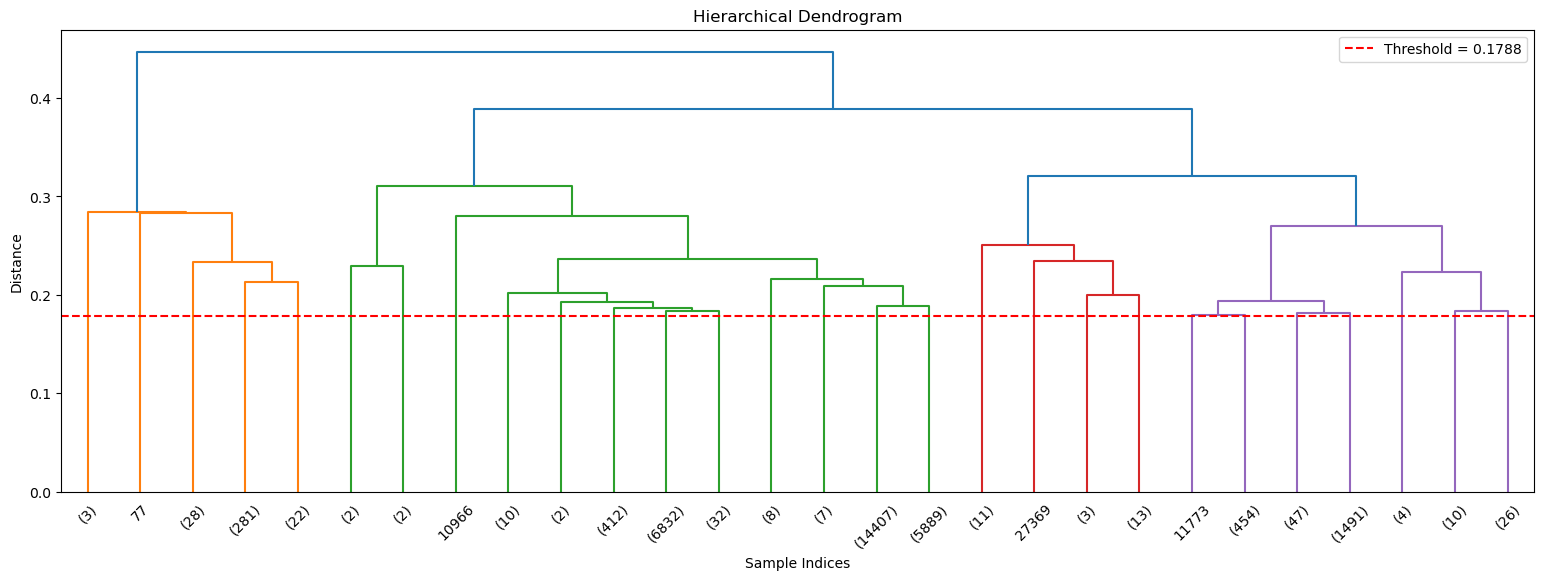

For threshold = 0.2682
Silhouette score for K = 9, threshold = 0.2682 is 0.3992


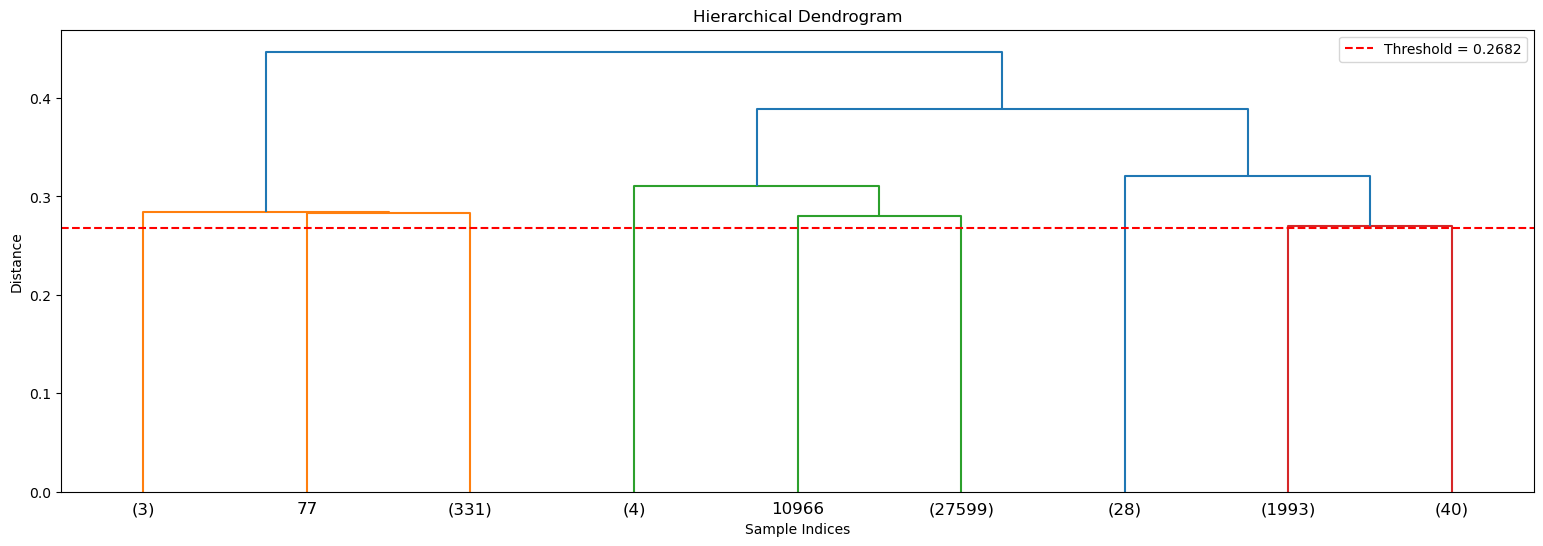

For threshold = 0.3576
Silhouette score for K = 3, threshold = 0.3576 is 0.3992


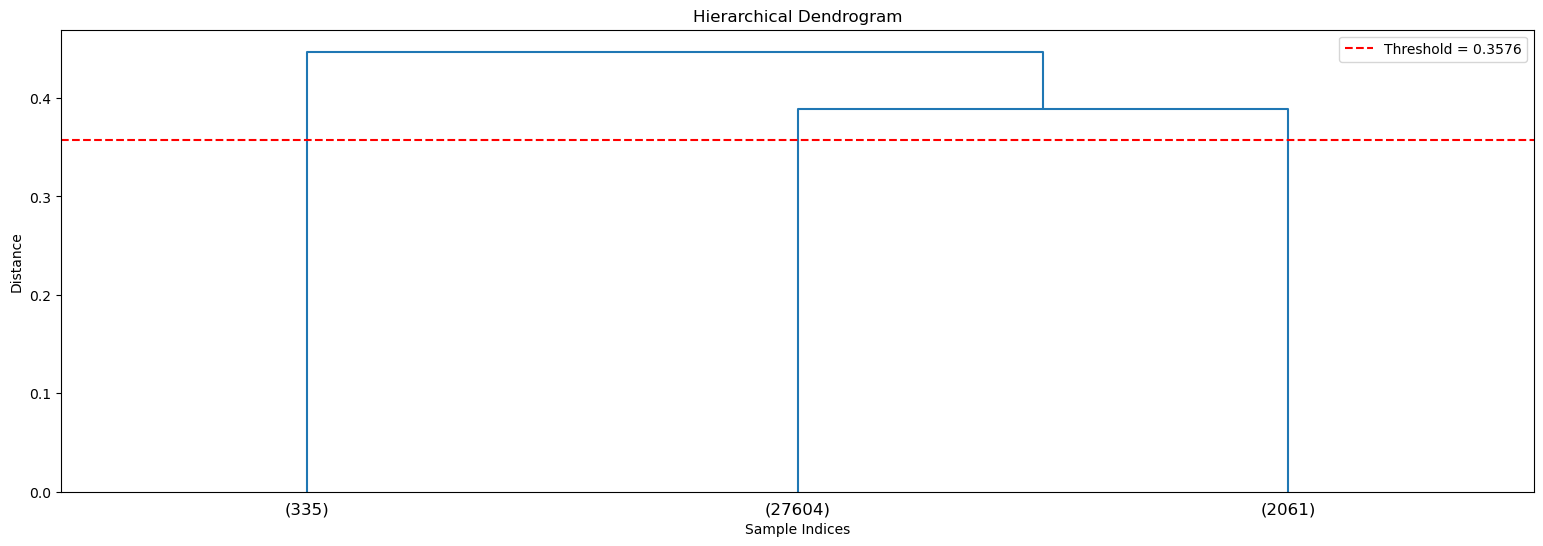

For threshold = 0.4471


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [18]:
# Prepare the features
features = data.drop('sentiment', axis=1)

# Perform hierarchical clustering using average linkage
hierarchical_clustering = linkage(features, method="average", metric="euclidean")

# Dynamically generate thresholds
# Get distances at which clusters are merged
merge_distances = hierarchical_clustering[:, 2]

# Select thresholds as evenly spaced values between the minimum and maximum merge distances
num_thresholds = 6  # Number of thresholds to generate
thresholds = np.linspace(merge_distances.min(), merge_distances.max(), num_thresholds)

# Dictionary to store results for each threshold
threshold_results = {}

# Iterate over the generated thresholds
for threshold in thresholds:
    print(f"For threshold = {threshold:.4f}")
    clusters = fcluster(hierarchical_clustering, t=threshold, criterion='distance')
    unique_clusters = np.unique(clusters)

    features['Cluster'] = clusters
    threshold_results[threshold] = features.copy()
    
    silhouette_val = silhouette_score(features.drop(columns=['Cluster']), clusters, metric='euclidean')
    print(f"Silhouette score for K = {len(unique_clusters)}, threshold = {threshold:.4f} is {silhouette:.4f}")

    plt.figure(figsize=(19, 6))
    dendrogram(hierarchical_clustering, p=len(unique_clusters), truncate_mode='lastp')
    plt.title('Hierarchical Dendrogram')
    plt.xlabel('Sample Indices')
    plt.ylabel('Distance')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.legend()
    plt.show()

this is not an actual error, it indicates that in the iteration where the error occurred, all data points were assigned to the same cluster (i.e., there is only one unique cluster label).


Pour seuil = 0.25
Silhouette_score pour K = 10, seuil = 0.25 est 0.8292490917133963


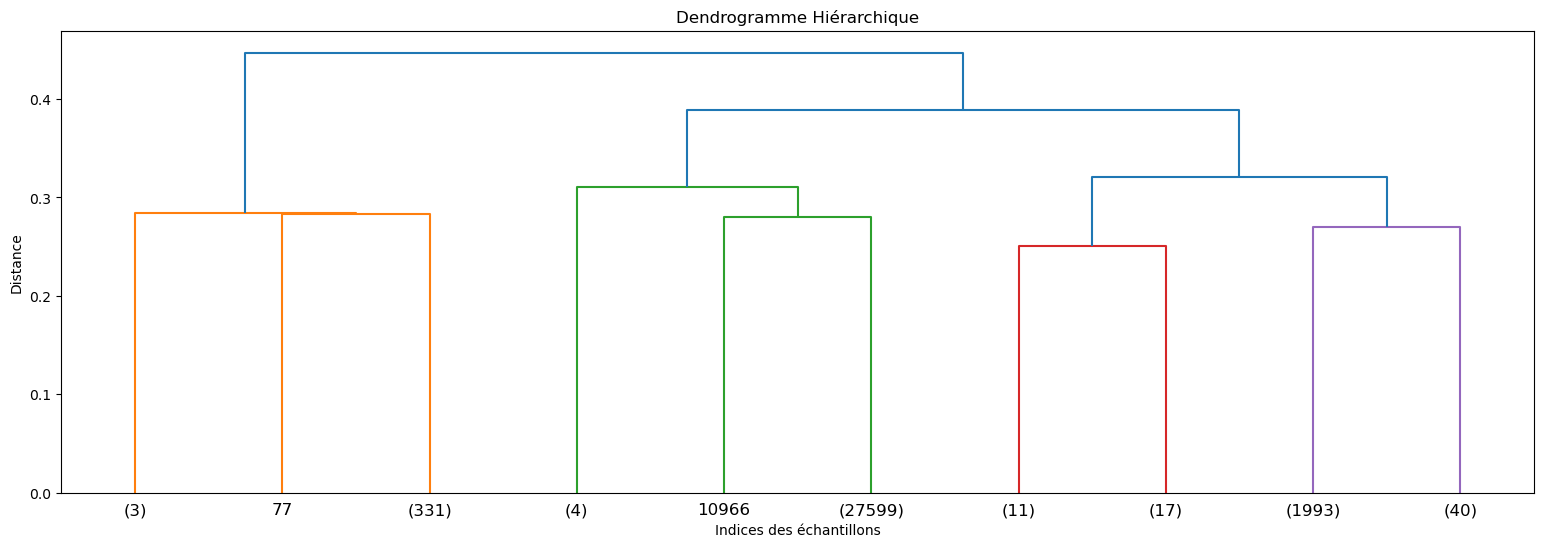

Pour seuil = 0.28
Silhouette_score pour K = 7, seuil = 0.28 est 0.8313737689178262


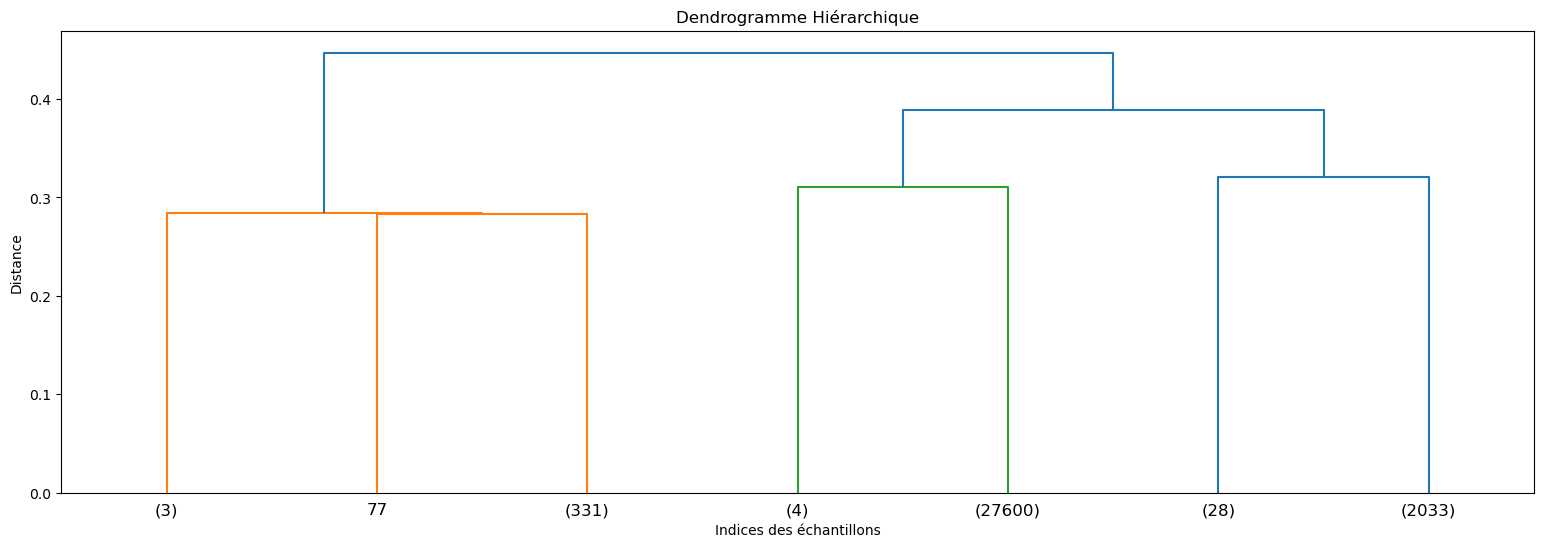

Pour seuil = 0.3
Silhouette_score pour K = 5, seuil = 0.3 est 0.8315641770304552


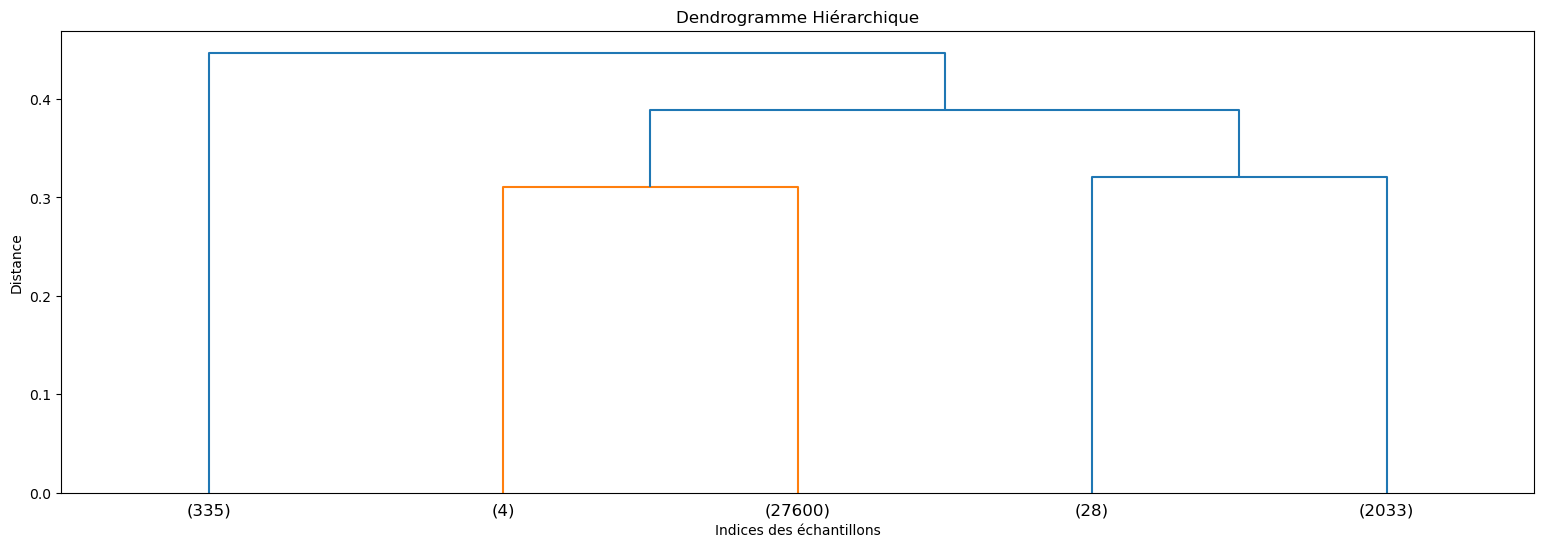

Pour seuil = 0.32
Silhouette_score pour K = 4, seuil = 0.32 est 0.835258881795481


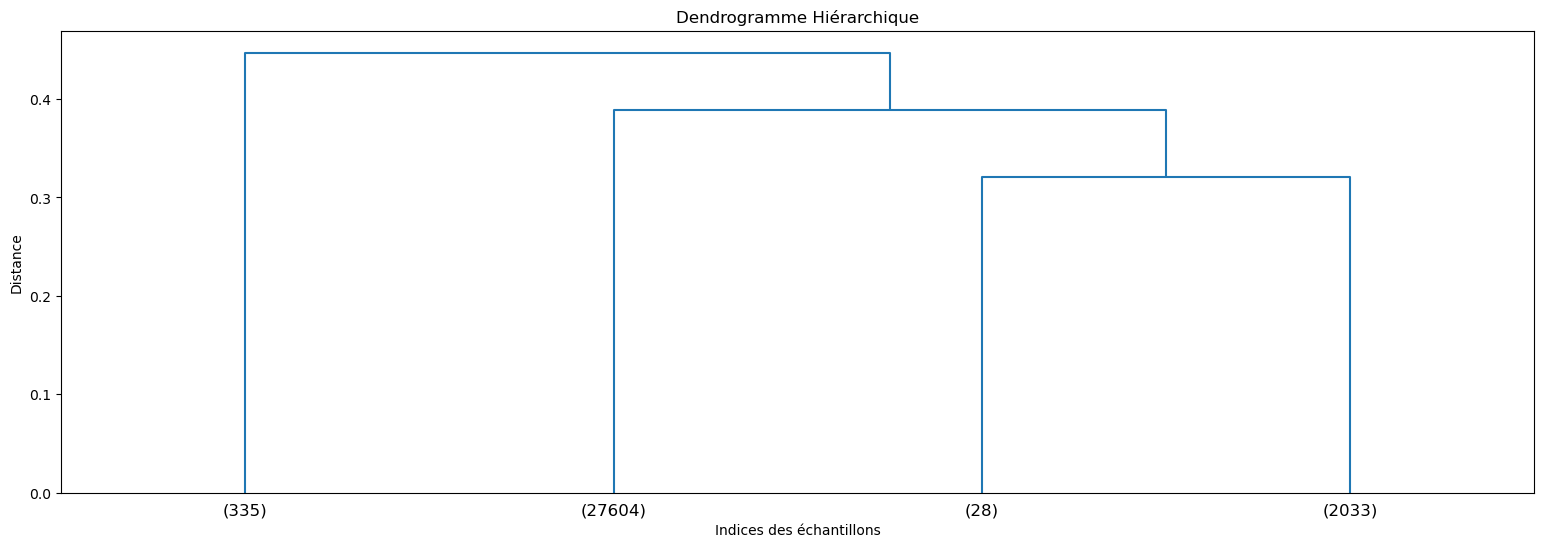

Pour seuil = 0.35
Silhouette_score pour K = 3, seuil = 0.35 est 0.8310660297715272


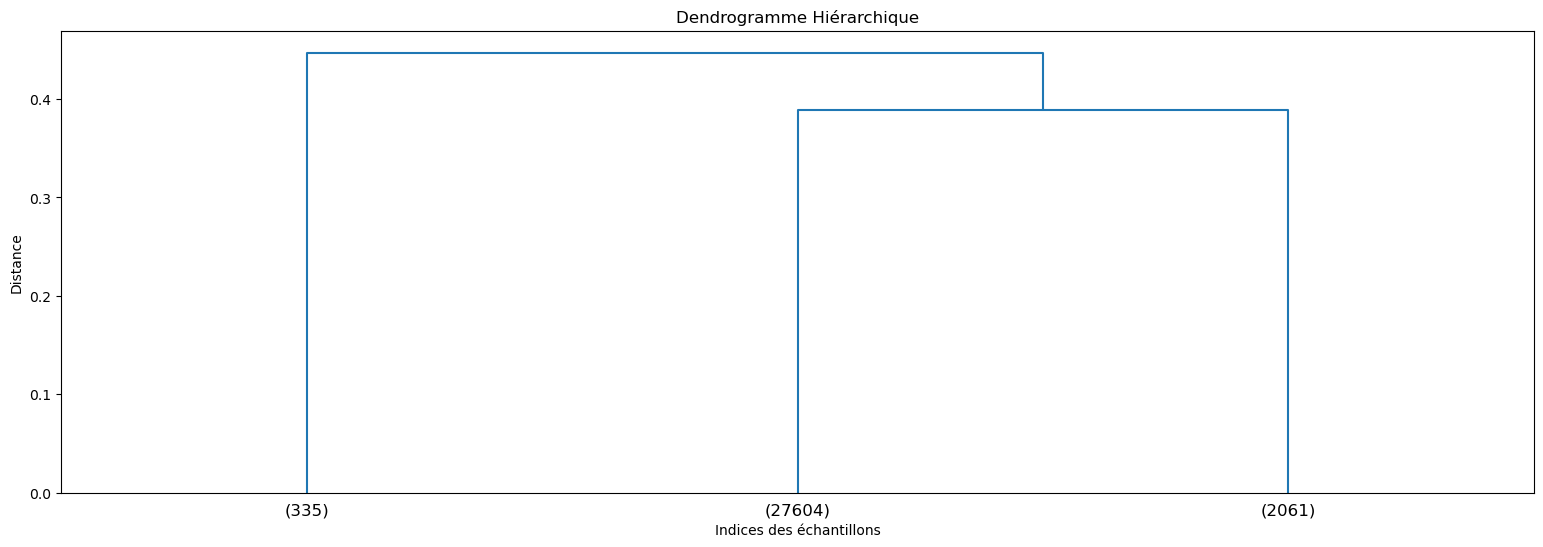

Pour seuil = 0.4
Silhouette_score pour K = 2, seuil = 0.4 est 0.8155255824340303


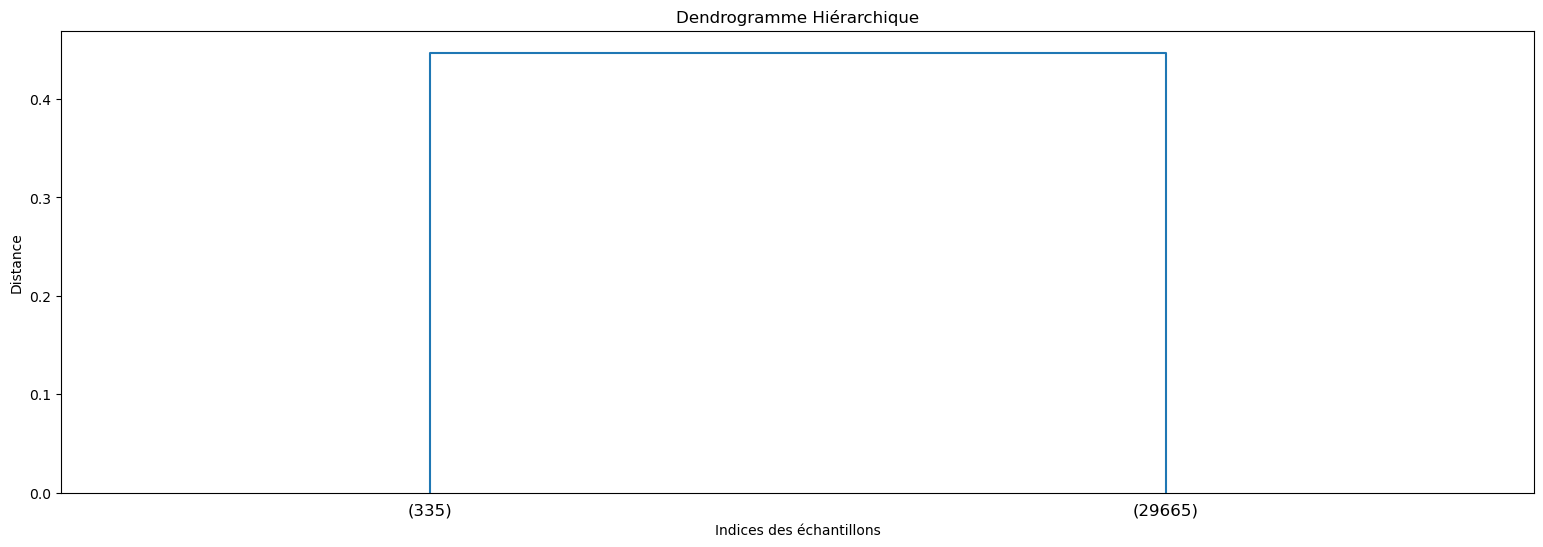

In [13]:
features = data.drop('sentiment', axis=1)
average_clustering = linkage(features, method="average", metric="euclidean")

df_seuils = {}

for seuil in ( 0.25, 0.28, 0.30, 0.32, 0.35, 0.4):
    print(f"Pour seuil = {seuil}")
    clusters = fcluster(average_clustering, t=seuil, criterion = 'distance')
    unique_clusters = np.unique(clusters)

    features['Cluster'] = clusters
    df_seuils[seuil] = features.copy()

    silhouette_score = metrics.silhouette_score(features, clusters, metric = 'euclidean')
    print(f'Silhouette_score pour K = {len(unique_clusters)}, seuil = {seuil} est {silhouette_score}')

    plt.figure(figsize=(19, 6))
    dendrogram(average_clustering, p = len(unique_clusters), truncate_mode='lastp')
    plt.title('Dendrogramme Hiérarchique')
    plt.xlabel('Indices des échantillons')
    plt.ylabel('Distance')
    plt.show()
